<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/convenience_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 利便性

In [3]:
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 5.4 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [70]:
score_name = '利便性スコア'
output_score_file = 'convenience_score.csv'

### 人口マスタ

In [5]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


### コンビニ・スーパー

In [21]:
df_convini_master = pd.read_csv(os.path.join(DIR_NAME, 'convenience_store.csv'))[['name', 'lat', 'lng']]
df_convini_master['施設分類'] = 'コンビニ'
df_convini_master = df_convini_master.rename(columns={'lat':'緯度', 'lng':'経度'})
print(df_convini_master.shape)

(6405, 4)


In [22]:
df_super_master = pd.read_csv(os.path.join(DIR_NAME, 'supermarket.csv'))[['name', 'lat', 'lng']]
df_super_master['施設分類'] = 'スーパー'
df_super_master = df_super_master.rename(columns={'lat':'緯度', 'lng':'経度'})
print(df_super_master.shape)

(2060, 4)


### 最寄駅

In [33]:
df_station_master = pd.read_csv(os.path.join(DIR_NAME, 'train_station.csv'))[['no', 'name', 'lat', 'lng']]
df_station_master = df_station_master.rename(columns={'no':'地域ID', 'name':'最寄駅'})
print(df_station_master.shape)

(3141, 4)


In [20]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

### スコア

In [27]:
%%time
# 1km以内の施設の数
df_pop_master['コンビニ(数)'] = get_value_of_nearest_facility(df_pop_master, df_convini_master, 'コンビニ', 'count', 1)
# 近い3件の距離の平均
df_pop_master['コンビニ(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_convini_master, 'コンビニ', 'mean', 3)
# 1km以内の施設の数
df_pop_master['スーパー(数)'] = get_value_of_nearest_facility(df_pop_master, df_super_master, 'スーパー', 'count', 1)

CPU times: user 19min 1s, sys: 3.92 s, total: 19min 4s
Wall time: 20min 20s


In [34]:
# 最寄駅からの距離
pop_master_len = len(df_pop_master)
df_pop_master = pd.merge(df_pop_master, df_station_master, on='地域ID', how='left')
assert len(df_pop_master) == pop_master_len

df_pop_master['最寄駅(距離)'] = df_pop_master.apply(lambda x: get_distance(x['緯度'], x['経度'], x['lat'], x['lng']), axis=1)
df_pop_master = df_pop_master.drop(columns=['lat', 'lng'])

In [35]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 11)


,地域ID,市区町村名,町名,町丁目,緯度,経度,コンビニ(数),コンビニ(平均距離),スーパー(数),最寄駅,最寄駅(距離)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,167,0.039658,13,東京駅,0.054248
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,148,0.101209,10,東京駅,0.315152
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,148,0.101844,9,有楽町駅,0.228117
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,153,0.069556,7,大手町駅,0.317383
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,169,0.128402,15,大手町駅,0.488932


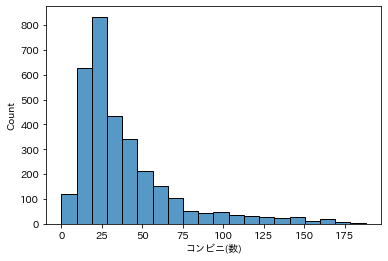

In [71]:
sns.histplot(df_pop_master['コンビニ(数)'], bins=20)
plt.show()

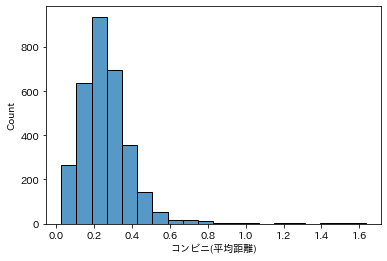

In [72]:
sns.histplot(df_pop_master['コンビニ(平均距離)'], bins=20)
plt.show()

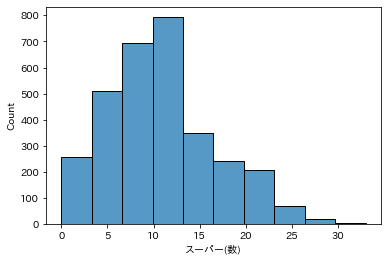

In [73]:
sns.histplot(df_pop_master['スーパー(数)'], bins=10)
plt.show()

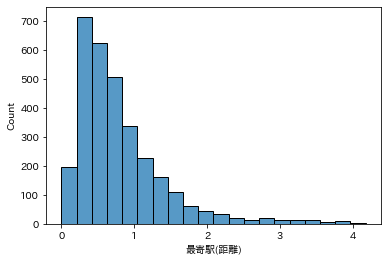

In [74]:
sns.histplot(df_pop_master['最寄駅(距離)'], bins=20)
plt.show()

In [75]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

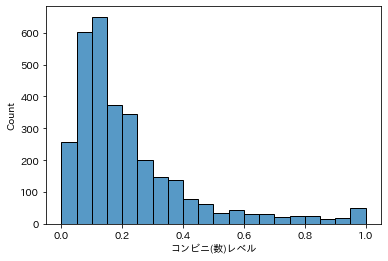

In [76]:
df_pop_master['コンビニ(数)レベル'] = normalize_score(df_pop_master['コンビニ(数)'])
sns.histplot(df_pop_master['コンビニ(数)レベル'], bins=20)
plt.show()

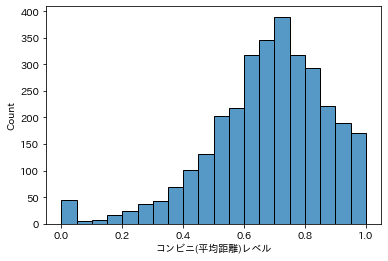

In [77]:
df_pop_master['コンビニ(平均距離)レベル'] = normalize_score(df_pop_master['コンビニ(平均距離)'], high=False)
sns.histplot(df_pop_master['コンビニ(平均距離)レベル'], bins=20)
plt.show()

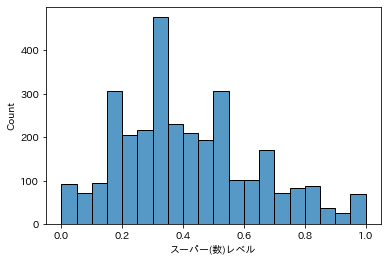

In [78]:
df_pop_master['スーパー(数)レベル'] = normalize_score(df_pop_master['スーパー(数)'])
sns.histplot(df_pop_master['スーパー(数)レベル'], bins=20)
plt.show()

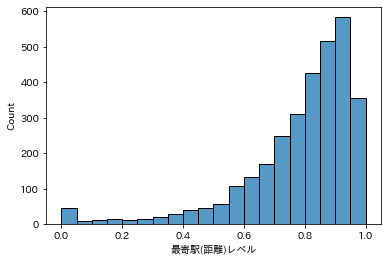

In [79]:
df_pop_master['最寄駅(距離)レベル'] = normalize_score(df_pop_master['最寄駅(距離)'], high=False)
sns.histplot(df_pop_master['最寄駅(距離)レベル'], bins=20)
plt.show()

In [80]:
score_list = [
    df_pop_master['コンビニ(数)レベル'] * 0.8,
    df_pop_master['コンビニ(平均距離)レベル'] * 0.6,
    df_pop_master['スーパー(数)レベル'] * 0.7,
    df_pop_master['最寄駅(距離)レベル'] * 1.0,
]
score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

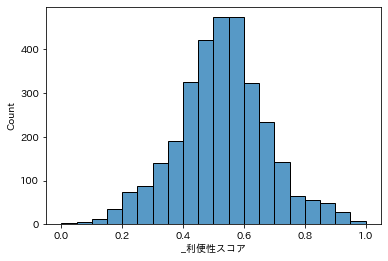

In [81]:
sns.histplot(df_pop_master[score_sub_name], bins=20)
plt.show()

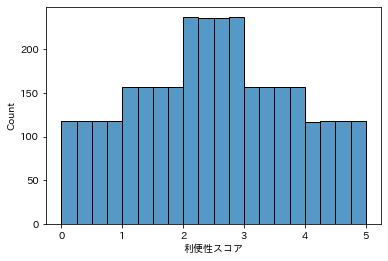

In [82]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [89]:
feature_list = ['コンビニ(数)', 'コンビニ(平均距離)', 'スーパー(数)', '最寄駅(距離)', '最寄駅']

In [90]:
df_pop_master[
    ['地域ID', '市区町村名', '町丁目'] + feature_list + [score_sub_name, score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

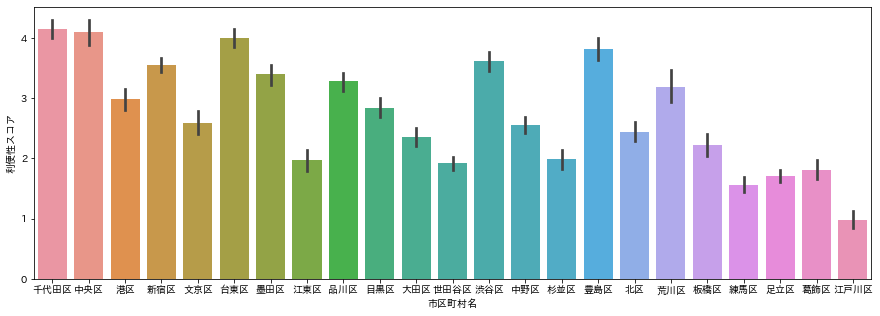

In [91]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [92]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + [score_name, score_sub_name] + feature_list
].reset_index(drop=True)
print(df_level.shape)

(911, 10)


In [93]:
df_level.head(20)

,市区町村名,町名,町丁目,利便性スコア,_利便性スコア,コンビニ(数),コンビニ(平均距離),スーパー(数),最寄駅(距離),最寄駅
0,新宿区,歌舞伎町,歌舞伎町１丁目,5.000000,1.000000,165,0.051609,26,0.150929,西武新宿駅
1,中央区,日本橋室町,日本橋室町２丁目,4.997878,0.980056,175,0.066614,25,0.243495,新日本橋駅
2,中央区,日本橋本町,日本橋本町２丁目,4.993633,0.965427,150,0.081322,25,0.237007,新日本橋駅
3,新宿区,西新宿,西新宿７丁目,4.991510,0.960168,161,0.082089,23,0.213538,西武新宿駅
4,豊島区,西池袋,西池袋１丁目,4.985143,0.943401,124,0.049731,30,0.155340,池袋駅
5,千代田区,神田花岡町,神田花岡町,4.983020,0.940753,141,0.059689,22,0.122307,秋葉原駅
6,中央区,日本橋本石町,日本橋本石町４丁目,4.980898,0.936915,176,0.086316,21,0.253162,新日本橋駅
7,千代田区,神田練塀町,神田練塀町,4.976653,0.935603,132,0.047826,25,0.283450,秋葉原駅
8,千代田区,神田平河町,神田平河町,4.972408,0.927198,135,0.031296,23,0.241374,秋葉原駅
9,千代田区,神田佐久間町,神田佐久間町１丁目,4.970285,0.924817,139,0.041618,21,0.156861,秋葉原駅


In [94]:
df_level.tail(20)

,市区町村名,町名,町丁目,利便性スコア,_利便性スコア,コンビニ(数),コンビニ(平均距離),スーパー(数),最寄駅(距離),最寄駅
891,千代田区,千代田,千代田,0.271676,0.248572,20,0.762506,0,0.951987,大手町駅
892,江戸川区,江戸川,江戸川２丁目,0.267431,0.244885,17,0.336220,9,2.837504,市川塩浜駅
893,江戸川区,西小松川町,西小松川町,0.254696,0.240889,14,0.521253,6,1.963524,平井駅
894,江戸川区,船堀,船堀７丁目,0.252573,0.240716,25,0.160610,7,3.763013,葛西臨海公園駅
895,江戸川区,一之江,一之江６丁目,0.250451,0.239882,25,0.190894,8,3.708306,平井駅
896,大田区,京浜島,京浜島１丁目,0.235594,0.237611,2,0.835906,0,0.789487,昭和島駅
897,練馬区,西大泉町,西大泉町,0.229226,0.235260,8,0.540507,4,1.674978,保谷駅
898,江戸川区,下篠崎町,下篠崎町,0.220736,0.230706,9,0.188782,3,2.778613,本八幡駅
899,江戸川区,新堀,新堀１丁目,0.195267,0.224646,16,0.278705,6,2.939070,新小岩駅
900,江戸川区,一之江町,一之江町,0.163430,0.216216,31,0.296719,8,3.766315,平井駅
